# Single nucleotide polymorphisms (SNPs)

This notebook looks in more detail at how single nucleotide polymorphisms (SNPs) are represented in the Ag1000G phase 3 (Ag3) data release. We'll also look at the different site filters that we've created to help select high quality SNPs for robust population genetic analyses. As always, this notebook is executable, click the launch icon (@@) and select a cloud computing service if you'd like to try running it for yourself.


## Setup

Before we get started, install some packages and set up access to the Ag3 data.

In [1]:
# TODO release new malariagen_data
!pip install -q malariagen_data
!pip install -q scikit-allel  # this will take about a minute or so to compile 

     |████████████████████████████████| 112kB 7.1MB/s 
     |████████████████████████████████| 133kB 11.2MB/s 
     |████████████████████████████████| 5.8MB 7.7MB/s 
     |████████████████████████████████| 1.3MB 37.3MB/s 
     |████████████████████████████████| 296kB 44.1MB/s 
     |████████████████████████████████| 143kB 54.9MB/s 
     |████████████████████████████████| 10.8MB 7.9MB/s 


In [9]:
from collections import Counter
import gzip
from functools import lru_cache
import pandas as pd
import numpy as np
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': False})
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import allel
from dask.diagnostics.progress import ProgressBar
%matplotlib inline

In [2]:
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

## Preface: navigating the reference genome

In case you're not already familiar with the *Anopheles gambiae* genome, here's a quick primer on how it's structured and how we refer to specific sites (locations) within the genome.

For Ag1000G analyses we use the AgamP4 reference genome. This genome is comprised of five main sequences:

In [4]:
contigs = "2R", "2L", "3R", "3L", "X"

Each of these identifiers (e.g., "2R") refers to a sequence of nucleotides, i.e., a sequence of the letters "A", "C", "T" and "G". Let's see how long these sequences are.

In [5]:
for contig in contigs:
    seq = ag3.genome_sequence(contig)
    print(f"{contig}: {len(seq):,} bp")

2R: 61,545,105 bp
2L: 49,364,325 bp
3R: 53,200,684 bp
3L: 41,963,435 bp
X: 24,393,108 bp


Let's take a peek at the first 100 letters in one of the sequences (2R).

In [6]:
seq = ag3.genome_sequence("2R").compute()
seq[:100].tobytes().decode().upper()

'CTCTAAACATTAATAAAACCAAATACATGATCATATCAAACAAAAATAATCAAGAACAGCTGTGTATTTCAATAAATCAAGAACATATAGACAATACTTC'

Here "bp" is short for base pair, which is the unit of length of nucleotide sequences. I.e., if a sequence is 10 bp then it is 10 nucleotides (letters) long.

In the case of *Anopheles gambiae*, these sequences correspond to chromosome arms. "2R" and "2L" are the two parts (arms) of Chromosome 2. "3R" and "3L" are the arms of Chromosome 3. "X" is the X chromosome. The X chromosome is a sex chromosome, present in two copies in females and one copy in males. Chromosomes 2 and 3 are autosomes, meaning that both males and females carry two copies. 

To refer to a specific site (position) within a sequence, we typically use 1-based coordinates. E.g., "2R:10" refers to the tenth nucleotide (letter) in the 2R sequence. We can access this nucleotide via Python, but when indexing in Python we need to remember to use zero-based indices. E.g., access the nucleotide at position 10 on chromosome arm 2R:

In [7]:
seq[9].decode().upper()

'T'

This nucleotide is a "T" (thymine).

Note that there are also some "gaps" in the reference genome, where we don't know what the nucleotide is. These are represented in the sequence with the letter "N". Let's take a look at how common these are, for chromosome arm 2R: 

In [8]:
Counter(seq).most_common()

[(b'T', 14379951),
 (b'A', 14377315),
 (b'C', 12197820),
 (b'G', 12183243),
 (b't', 2077134),
 (b'a', 2060370),
 (b'g', 1430905),
 (b'c', 1425715),
 (b'n', 1412612),
 (b'N', 40)]

There are two things to notice here. First, there are both upper case and lower case letters. For most purposes you can ignore this, e.g., both "T" and "t" mean the same thing. Second, there are 1,412,652 nucleotides which are unknown (either "N" or "n").

To gain a bit more intuition for how the genome is structured and the relative sizes of the different sequences, let's make a simple plot of the five chromosome arms.

In [9]:
def plot_sequence_composition(seq_id, window_size=100_000, ax=None):
    
    # load reference sequence
    seq = ag3.genome_sequence(seq_id).compute()
    
    if ax is None:
        # make the figure size relative to largest contig
        figw = 11 * len(seq) / len(ag3.genome_sequence("2R"))
        fig, ax = plt.subplots(figsize=(figw, 1))
 
    # convert to upper-case
    seq = np.char.upper(seq)

    # locate nucleotides
    is_a = seq == b'A'
    is_c = seq == b'C'
    is_g = seq == b'G'
    is_t = seq == b'T'
    is_n = seq == b'N'
    # check there's nothing unexpected
    is_other = ~is_a & ~is_c & ~is_g & ~is_t & ~is_n
    assert np.sum(is_other) == 0

    # construct windows
    bins = np.arange(0, len(seq), window_size)

    # count nucleotides in each window
    h_a, _ = np.histogram(np.nonzero(is_a)[0] + 1, bins=bins)
    h_c, _ = np.histogram(np.nonzero(is_c)[0] + 1, bins=bins)
    h_g, _ = np.histogram(np.nonzero(is_g)[0] + 1, bins=bins)
    h_t, _ = np.histogram(np.nonzero(is_t)[0] + 1, bins=bins)
    h_n, _ = np.histogram(np.nonzero(is_n)[0] + 1, bins=bins)

    # plot frequence of nucleotides within each bin
    left = bins[:-1]
    bottom = 0
    width = np.diff(bins)
    palette = sns.color_palette('colorblind')
    colors = [palette[i] for i in [2, 0, 3, 8]] + ['k']
    for h, c, l in zip([h_a, h_t, h_g, h_c, h_n], colors, 'ATGCN'):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align='edge', label=l)
        bottom += h
        
    # tidy up plot
    ax.set_xlim(0, len(seq))
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(['0%', '100%'])
    ax.set_title(seq_id)
    # convert X axis to Mbp
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
    ax.set_xlabel("Position (Mbp)")
    
    # add centromere/telomere annotation
    if seq_id in {'2L', '3L'}:
        ltxt = "centromere"
        rtxt = "telomere"
    else:
        ltxt = "telomere"
        rtxt = "centromere"
    ax.annotate(ltxt, xy=(0, 1), xycoords="axes fraction", 
                xytext=(0, 2), textcoords='offset points', va='bottom', ha='left')
    ax.annotate(rtxt, xy=(1, 1), xycoords="axes fraction", 
                xytext=(0, 2), textcoords='offset points', va='bottom', ha='right')
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=(1, .5), 
              prop=dict(family='monospace'), ncol=2,
              frameon=False)
        

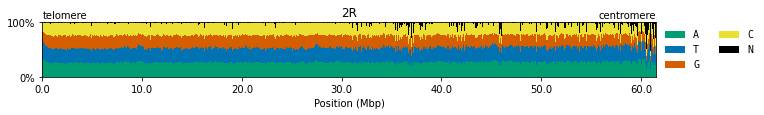

In [10]:
plot_sequence_composition('2R')

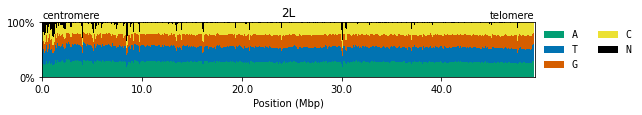

In [11]:
plot_sequence_composition('2L')

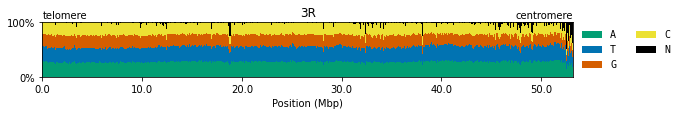

In [12]:
plot_sequence_composition('3R')

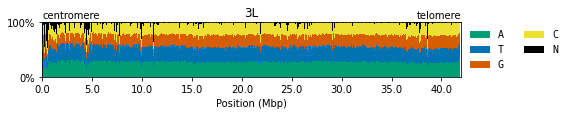

In [14]:
plot_sequence_composition('3L')

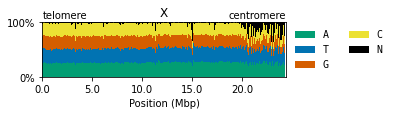

In [15]:
plot_sequence_composition('X')

A few points to note about the plots above:

1. All of the chromosome arms are made up of A, C, T and G in roughly equal proportion, although A and T are a little more common than C and G.

1. We annotated each chromosome arm with "[centromere](https://www.genome.gov/genetics-glossary/Centromere)" and "[telomere](https://www.genome.gov/genetics-glossary/Telomere)". You probably don't need to know what these mean, but it is worth knowing that the sequences at these two different ends of the chromosome tend to be quite different, especially towards the centromere. 

1. Gaps (N) are relatively uncommon, except towards the centromere of all chromosome arms where they are more common. This is typically because sequences are more repetitive towards the centromeres and so assembling the genome is more difficult. 

1. We made the size of each figure proportional to the length of the sequence. This was to help give a feeling for the relative size of the different chromosome arms. 

1. We converted the X-axis coordinates to "Mbp" which means mega-base pairs, i.e., millions of letters.

Now we're acquainted with the reference genome, let's look at nucleotide variation.

## SNP positions and alleles

When studying genetic variation in natural populations, there are two fundamental questions:

1. Where in the genome do we observe **differences (i.e., nucleotide variation)** between individual mosquitoes. 

2. Where in the genome do we observe **no differences (i.e., nucleotide conservation)** between individuals. 

Sometimes this second question is overlooked, but both questions are important.

In Ag1000G phase 3 we have taken a slightly different approach to calling single nucleotide polymorphisms (SNPs - single letter differences) than in previous project phases. Because we are interested in both of the above questions, **we have genotyped all individual mosquitoes at all genomic sites where the reference genotype nucleotide is known (i.e., not an "N"), regardless of whether any variation is present**. This is sometimes known as an "all sites" analysis. 

In order to simplify SNP calling across a large number of individuals, **we also declared the set of all possible alternate (variant) SNP alleles ahead of time**. Because we are analysing SNPs and we are not considering any other types of variation at this stage, then at each site in the genome there is one reference allele (i.e., the nucleotide in the reference genome) and three possible alternate alleles. E.g., at position 10 on chromosome arm 2R, the reference allele is "T", and so there are three possible alternate alleles: "A", "C" and "G".

Let's look at how these data are represented for chromosome arm 2R:

In [16]:
pos, ref, alt = ag3.snp_sites("2R")

The `pos` array here holds the 1-based positions (coordinates) where the SNPs were called. E.g., here's the first 10 SNP positions:

In [17]:
pos[:10].compute()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

Note that this is simply the positions 1-10. However, these positions **do not** continue increasing by 1 all the way through the array, i.e., there are gaps, because of gaps in the reference genome. We can quickly visualise that, by plotting the distance between adjacent sites:

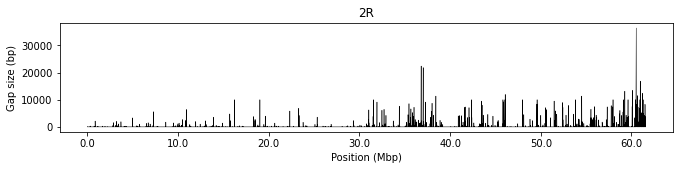

In [18]:
p = pos.compute()
d = np.diff(p)
fig, ax = plt.subplots(figsize=(11, 2))
ax.plot(p[1:], d, color='black', linewidth=.5)
ax.set_title("2R")
# convert X axis to Mbp
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
ax.set_xlabel("Position (Mbp)")
ax.set_ylabel('Gap size (bp)');

Note also that the length of the `pos` array is less than the length of the reference genome sequence:

In [19]:
len(seq) - len(pos)

1412652

This difference is the number of unknown nucleotides ("N"s) in the reference genome that we computed earlier. This is another way of confirming that we have called SNP genotypes at all genomic sites where the reference genome nucleotide is known.

The `ref` array holds the reference alleles, i.e., the reference genome nucleotide for each SNP site. E.g., here's the reference alleles at the first 10 SNP sites:

In [20]:
ref[:10].compute()

array([b'C', b'T', b'C', b'T', b'A', b'A', b'A', b'C', b'A', b'T'],
      dtype='|S1')

We can confirm that this corresponds to the nucleotides in the reference sequence by using the SNP positions to index the sequence (remembering to convert to zero-based coordinates):

In [21]:
np.take(seq, pos[:10] - 1)

array([b'C', b'T', b'c', b't', b'a', b'a', b'a', b'c', b'a', b't'],
      dtype='|S1')

The `alt` array holds the predefined alternate alleles at each site. E.g., here are the alternate alleles for the first 10 SNP sites:

In [22]:
alt[:10].compute()

array([[b'A', b'T', b'G'],
       [b'A', b'C', b'G'],
       [b'A', b'T', b'G'],
       [b'A', b'C', b'G'],
       [b'C', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'T', b'G'],
       [b'C', b'T', b'G'],
       [b'A', b'C', b'G']], dtype='|S1')

Each row represents a site, and the columns show the three possible alternate alleles.

The same applies if you are working with the data in VCF format. E.g., here's the first 10 rows of the VCF file with SNP genotypes for sample AR0001-C [previously downloaded](../download), note the three alternate (ALT) alleles at every site:

In [3]:
with gzip.open("../AR0001-C.vcf.gz", mode='rt') as f:
    count = 0
    for line in f:
        if not line.startswith("##"):
            print(line.strip())
            count += 1
        if count > 10:
            break

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	AR0001-C
2R	1	.	C	A,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=14.72	GT:AD:DP:GQ:PL	0/0:5,0,0,0:5:6:0,6,52,6,52,52,6,52,52,52
2R	2	.	T	A,C,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=13.44	GT:AD:DP:GQ:PL	0/0:6,0,0,0:6:6:0,6,53,6,53,53,6,53,53,53
2R	3	.	C	A,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=12.44	GT:AD:DP:GQ:PL	0/0:7,0,0,0:7:6:0,6,53,6,53,53,6,53,53,53
2R	4	.	T	A,C,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=12.44	GT:AD:DP:GQ:PL	0/0:7,0,0,0:7:6:0,6,53,6,53,53,6,53,53,53
2R	5	.	A	C,T,G	0.08	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=22.81	GT:AD:DP:GQ:PL	0/0:9,0,0,0:9:6:0,6,53,6,53,53,6,53,53,53
2R	6	.	A	C,T,G	0.02	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=28.78	GT:AD:DP:GQ:PL	0/0:10,0,0,0:10:12:0,12,113,12,113,113,12,113,113,113
2R	7	.	A	C,T,G	0.02	.	ExcessHet=3.0103;MLEAC=0,0,0;MLEAF=0.00,0.00,0.00;MQ=27.68	GT:AD:DP:GQ:PL	0/0:11,0,

The most important thing to note about the SNP data in Ag3 is that **not all of these alternate alleles will have been observed in the mosquitoes we sequenced.**

To determine which alternate alleles are observed in Ag3, we need to look at the SNP genotypes. Let's take a look at how SNP genotypes are represented, then return to the question of which alternate alleles have been observed.

## Genotypes

Here a SNP "genotype" means the pair of nucleotides (alleles) carried by an individual mosquito at a specific site in the genome. Note that this is a pair of alleles because mosquitoes are diploid like us, meaning that they carry two copies of their genome, one inherited from each parent (except for males on the X chromosome, which inherit one copy from their mother only).

Rather than storing the actual nucleotides for each genotype, it is conventional to use a numerical encoding of genotypes, where 0 stands for the reference allele, 1 stands for the first alternate allele, 2 stands for the second alternate allele, 3 stands for the third alternate allele, etc.

E.g., at site 2R:10 the reference allele is "T". If an individual mosquito carries a homozygous reference genotype (both genome copies have a "T"), we represent this in Python as the pair of integers `(0, 0)`. In a VCF file this is represented as the string "0/0".

At 2R:10 we have arbitrarily declared that "A" is the first alternate allele. If an individual carries a heterozygous genotype, where one genome copy has "T" and the other has "A", this is represented as the pair `(0, 1)`. The ordering of this pair has no meaning.

Similarly, at 2R:10 we have arbitrarily declared that "C" is the second alternate allele and "G" is the third alternate allele. So, a genotype homozygous for the "C" allele would be represented as `(2, 2)`, a genotype homozygous for "G" would be `(3, 3)` and a genotype heterozygous for the "C" and "G" alleles would be `(2, 3)`.

There's one more thing to know. Sometimes a genotype is called as missing, meaning that there were no sequence reads for the given individual at a given site. In Python we represent this as a pair of negative numbers `(-1, -1)`. In VCF this is represented as the string "./.".

Here are those example genotypes again, shown as a table with the different representations:

<div class="cell_output">
<table border="1" class="dataframe">
<thead>
<tr>
<th>Reference allele</th>
<th>Alternate alleles</th>
<th>Genotype</th>
<th>Genotype (Python)</th>
<th>Genotype (VCF)</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<th rowspan="7">T</td>
<th rowspan="7">A,C,G</td>
<td>T/T</td>
<td><code>(0, 0)</code></td>
<td>0/0</td>
<td>homozygous reference</td>
</tr>
<tr>
<td>T/A</td>
<td><code>(0, 1)</code></td>
<td>0/1</td>
<td>heterozygous</td>
</tr>
<tr>
<td>A/A</td>
<td><code>(1, 1)</code></td>
<td>1/1</td>
<td>homozygous alternate</td>
</tr>
<tr>
<td>C/C</td>
<td><code>(2, 2)</code></td>
<td>2/2</td>
<td>homozygous alternate</td>
</tr>
<tr>
<td>G/G</td>
<td><code>(3, 3)</code></td>
<td>3/3</td>
<td>homozygous alternate</td>
</tr>
<tr>
<td>C/G</td>
<td><code>(2, 3)</code></td>
<td>2/3</td>
<td>heterozygous</td>
</tr>
<tr>
<td>missing</td>
<td><code>(-1, -1)</code></td>
<td>./.</td>
<td>missing</td>
</tr>
</tbody>
</table>
</div>
<br/>

To see this in action, let's access the SNP genotypes for chromosome arm 2R for all wild samples in Ag3.

In [23]:
gt = ag3.snp_genotypes(contig="2R", sample_sets="v3")
gt.shape

(60132453, 3081, 2)

The `gt` array has three dimensions. The first dimension corresponds to the genomic sites we've analysed (in this case, there are 60,132,453 sites on chromosome arm 2R). The second dimension (3,081) is the number of individual mosquitoes (a.k.a. samples) sequenced. The third dimension (2) represents the two alleles in each individual genotype.

So, e.g., let's look up the genotype call at the 10th site in the 1st sample:

In [24]:
gt[9, 0].compute()

array([0, 0], dtype=int8)

This is a homozygous reference genotype.

Let's try another, the 10th site and the 2,393rd sample.

In [25]:
gt[9, 2392].compute()

array([0, 2], dtype=int8)

This is a heterozygous genotype, where the reference allele and the second alternate allele are both present.

Let's look at one more genotype, the 10th site and the 249th sample.

In [26]:
gt[9, 248].compute()

array([-1, -1], dtype=int8)

This is a missing genotype call.

When working with genotype arrays it can be useful to use the scikit-allel package. Let's wrap the `gt` variable, which is a general purpose [dask array](https://docs.dask.org/en/latest/array.html), with the scikit-allel `GenotypeDaskArray` class, which provides some useful functionality for analysing genotype data.

In [27]:
gt = allel.GenotypeDaskArray(gt)
gt

<GenotypeDaskArray shape=(60132453, 3081, 2) dtype=int8>

This wrapper class provided a display showing a preview of genotype calls for the first and last sites and samples, using the VCF-style representation of genotype calls (e.g., "0/0" is homozygous reference, etc.).

Once we have access to the genotype calls, we can run a variety of different computations. A common computation needed for many analyses is an allele count, which we'll look at next.

## Allele counts

An allele count involves scanning across all the genotypes at a given site and counting the number of times each allele is observed. I.e., how many 0s, 1s, 2s and 3s are observed. Let's do an allele count for the first 10 sites on chromosome arm 2R.

In [28]:
ac = gt[:10].count_alleles(max_allele=3).compute()
ac.displayall()

,0,1,2,3
0,5871,2,1,0
1,5930,0,5,1
2,5981,7,2,0
3,6033,1,2,0
4,6050,0,0,0
5,6070,1,0,3
6,6080,4,0,0
7,6073,2,6,15
8,6118,0,1,1
9,6120,1,4,1


In the `ac` array above, each row represents a site, and the four columns represent the four alleles. The values are the number of times each allele was observed at each site. So, now we can see which alleles have been observed in the Ag3 data.

E.g., for the 10th site, the reference allele (`0`) was observed 6120 times, the first alternate allele (`1`) was observed once, the second alternate allele (`2`) was observed four times, and the third alternate allele (`3`) was observed once. So, this is a site where in fact all four possible alleles (nucleotides) were observed in Ag3 samples. This is an example of a multiallelic site.

Let's look at some other sites. 

At the fifth site, only the reference allele was observed. This is an example of an invariant site. I.e., there is no variation there, all samples were homozygous for the reference allele or had a missing genotype call.

At the seventh site, two alleles were observed, the reference allele and the first alternate allele. This is an example of a biallelic site. Note that biallelic sites might involve any pair of alleles, not always `0` and `1`.

Let's use this allele counts array to compute some properties of these 10 sites.

In [29]:
# how many alleles were observed
ac.allelism()

array([3, 3, 3, 3, 1, 3, 2, 4, 3, 4])

In [30]:
# whether any alternate alleles were observed
ac.is_variant()

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [31]:
# whether more than one allele was observed
ac.is_segregating()

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [32]:
# whether exactly two alleles were observed
ac.is_biallelic()

array([False, False, False, False, False, False,  True, False, False,
       False])

In [33]:
# total number of alleles called
an_called = ac.sum(axis=1)
an_called

array([5874, 5936, 5990, 6036, 6050, 6074, 6084, 6096, 6120, 6126])

In [34]:
# total number of missing allele calls
an_missing = (gt.shape[1] * 2) - an_called
an_missing

array([288, 226, 172, 126, 112,  88,  78,  66,  42,  36])

These arrays can be useful when selecting which sites to use for a given analysis. For example, you might want to select only segregating sites, with at most a certain number of missing allele calls.

Now we've seen how SNP positions, alleles and genotypes are represented, let's look at the site filters we've created for Ag3 to help select sites for robust population genetic analyses.

## Site filters

When analysing genome variation, there are some sites in the genome where it is difficult to reliably ascertain nucleotide variation and call genotypes. This can be for a variety of reasons. For example, some genome regions are very repetitive, and short sequence reads cannot be aligned unambiguously. Another issue can be that some samples have structural variation in some regions of the genome, where different samples have different numbers of copies of a given sequence. 

To identify and avoid sites like these, we have created site filters. These are Boolean masks which identify sites where SNP genotyping is reliable, based on the fact that most sequence reads are unambiguously aligned, and there is minimal evidence for structural variation. 

Because we have three separate species included in the Ag3 cohort (*An. gambiae*, *An. coluzzii* and *An. arabiensis*) we have created three different site filters which are appropriate in different circumstances, depending on which samples you're analysing. Here is a summary of the three site filters:

* "gamb_colu_arab" - These site filters are appropriate when performing a joint analysis of samples from any of the three species. They are, however, more stringent the other filters, which we'll explore further below.
* "gamb_colu" - These site filters are appropriate when analysing only samples that are not *An. arabiensis*.
* "arab" - These sige filters are appropriate when analysing only samples that are *An. arabiensis*.

For each of these filters, there is one Boolean mask per chromosome arm. The Boolean masks are True where a site passes the filter and False otherwise. E.g., here's the `gamb_colu_arab` site filter for chromosome arm 2R:

In [4]:
loc_pass = ag3.site_filters(contig="2R", mask="gamb_colu_arab")
loc_pass

dask.array<array, shape=(60132453,), dtype=bool, chunksize=(300000,), chunktype=numpy.ndarray>

In [6]:
# examine the first ten values
loc_pass[:10].compute()

array([False, False, False, False, False, False, False, False, False,
       False])

In [5]:
# how many sites in total pass the filter?
loc_pass.sum().compute()

40561667

To get some intuition for what these site filters look like and how they differ from each other, let's build a summary table showing how many sites pass in each chromosome arm.

In [36]:
@lru_cache(maxsize=None)
def count_filter_pass(contig, mask):
    loc_pass = ag3.site_filters(contig=contig, mask=mask)
    n_pass = loc_pass.sum().compute()
    return n_pass

In [83]:
def tabulate_filter_counts():

    rows = []
    for contig in contigs:
        contig_length = len(ag3.genome_sequence(contig))
        n_sites = len(ag3.snp_sites(contig=contig, field="POS"))
        row = [contig, contig_length, n_sites]
        for mask in "gamb_colu_arab", "gamb_colu", "arab":
            n_pass = count_filter_pass(contig=contig, mask=mask)
            pc_pass = "{:.1%}".format(n_pass / n_sites)
            row.append(pc_pass)
        rows.append(row)
    df = pd.DataFrame.from_records(
        rows, 
        columns=["contig", "contig length", "no. sites", "pass gamb_colu_arab", "pass gamb_colu", "pass arab"]
    )
    return df

df_filter_counts = tabulate_filter_counts()
df_filter_counts

,contig,contig length,no. sites,pass gamb_colu_arab,pass gamb_colu,pass arab
0,2R,61545105,60132453,67.5%,73.9%,73.6%
1,2L,49364325,48525747,67.0%,74.2%,72.6%
2,3R,53200684,52226568,63.9%,71.2%,69.8%
3,3L,41963435,40758473,63.5%,70.4%,69.7%
4,X,24393108,23385349,48.0%,70.0%,53.3%


There's a couple of things to note about these numbers:

1. The percentage of sites passing the `gamb_colu_arab` filter is always lower than either the `gamb_colu` or `arab` filters. This is because the `gamb_colu_arab` filter is the intersection of the two other filters. I.e., a site passes the `gamb_colu_arab` filter if it passes **both** the `gamb_colu` and the `arab` filters.

1. The percentage of sites passing the `gamb_colu` and `arab` filters is similar on all chromosome arms, except for the X chromosome. This is because of a large inversion on the X chromosome known as Xag which is a fixed difference between *An. arabiensis* and the other two species, and where there is a higher level of divergence in *An. arabiensis* relative to the reference genome we've used. 

To gain a bit more intuition for these filters, let's plot the fraction of genome sites that pass the site filters in moving windows over each of the chromosome arms.

In [86]:
def plot_site_filters(contig, window_size=200_000, ax=None):

    # setup figure and axes
    if ax is None:
        contig_length = len(ag3.genome_sequence(contig))
        figw = 11 * contig_length / len(ag3.genome_sequence("2R"))
        fig, ax = plt.subplots(figsize=(figw, 2))
        sns.despine(ax=ax, offset=5)

    # setup X variable
    pos = ag3.snp_sites(contig=contig, field="POS").compute()
    x = allel.moving_statistic(pos, statistic=np.mean, size=window_size)

    # setup Y variables and plot
    for mask in "gamb_colu", "arab", "gamb_colu_arab":
        loc_pass = ag3.site_filters(contig=contig, mask=mask).compute()
        y = allel.moving_statistic(loc_pass, statistic=np.mean, size=window_size)
        ax.plot(x, y * 100, label=mask)

    # tidy plot
    ax.set_xlim(0, contig_length)
    ax.set_ylim(0, 100)
    ax.set_title(contig)
    # convert X axis to Mbp
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: x//1e6))
    ax.set_xlabel("Position (Mbp)")
    ax.set_ylabel('% pass')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Filter",
              frameon=False)



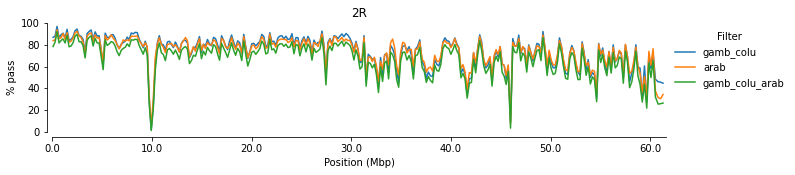

In [87]:
plot_site_filters(contig="2R")

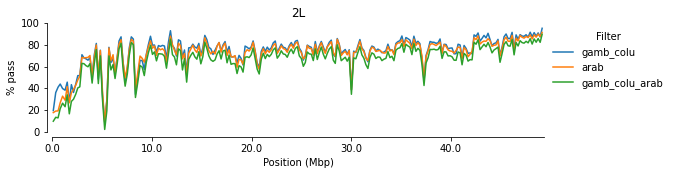

In [88]:
plot_site_filters(contig="2L")

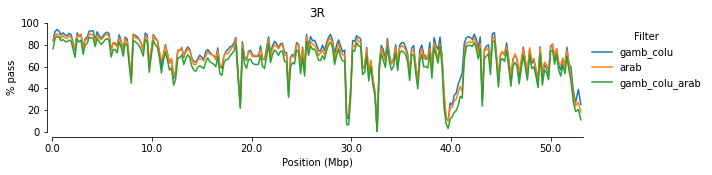

In [89]:
plot_site_filters(contig="3R")

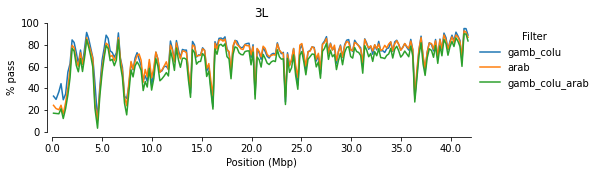

In [90]:
plot_site_filters(contig="3L")

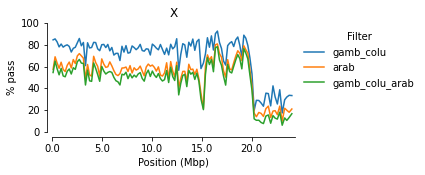

In [91]:
plot_site_filters(contig="X")

The methods in the `malariagen_data.Ag3` class allow you to access data on sites or genotypes with one of these filters already applied. E.g., let's access the sites with the `gamb_colu_arab` filter applied.

In [7]:
pos, ref, alt = ag3.snp_sites(contig="2R", site_mask="gamb_colu_arab")
pos

dask.array<getitem, shape=(40561667,), dtype=int32, chunksize=(455384,), chunktype=numpy.ndarray>

Notice the length of this array is 40,561,667 which we calculated earlier as the number of sites passing the `gamb_colu_arab` filter on chromosome arm 2R.

Similarly, here are the genotypes with the `gamb_colu_arab` site filter applied.

In [10]:
gt = ag3.snp_genotypes(contig="2R", sample_sets="v3", site_mask="gamb_colu_arab")
gt

,Array,Chunk
Bytes,249.94 GB,26.25 MB
Shape,"(40561667, 3081, 2)","(262530, 50, 2)"
Count,44650 Tasks,14874 Chunks
Type,int8,numpy.ndarray


## Selecting samples

Finally, let's look again at how the SNP genotypes correspond to the sample metadata, and how we can use queries on the sample metadata to select specific samples for further analysis.

First, let's load the sample metadata.

In [11]:
df_samples = ag3.sample_metadata(sample_sets="v3")
df_samples.head()

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,release,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species
0,AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,v3,0.945,0.001,gamb_colu,coluzzii,coluzzii
1,AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,v3,0.933,0.001,gamb_colu,coluzzii,coluzzii
2,AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,v3,0.937,0.002,gamb_colu,coluzzii,coluzzii
3,AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,v3,0.938,0.002,gamb_colu,coluzzii,coluzzii
4,AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F,AG1000G-AO,v3,0.926,0.001,gamb_colu,coluzzii,coluzzii


@@TODO query samples and apply selection and run a computation

## Further reading

@@TODO